# Initialization

In [ ]:
pip install shap

In [ ]:
# General Libraries
import json
import time
import warnings
import numpy as np
import pandas as pd
import scipy.stats as stats
from tqdm.notebook import tqdm
from collections import Counter
warnings.filterwarnings('ignore')

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from termcolor import colored

# Machine Learning
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier

# Imbalanced Dataset
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE, SMOTEN, ADASYN
from imblearn.under_sampling import TomekLinks

# SHapley Additive exPlanations (SHAP)
import shap

# Outlier Detection
from sklearn.neighbors import LocalOutlierFactor

# Extra
import joblib

# DataFrame Preparation

In [ ]:
# Data Source: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset/data
df = pd.read_csv('https://raw.githubusercontent.com/jdmamangun/DSFC12-S2G1/main/healthcare-dataset-stroke-data.csv')
df.columns = df.columns.str.lower()

In [ ]:
# Display the data and its basic information
display(df.info(), df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


None

,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


## Initial Exploratory Data Analysis (EDA)

### Correlation Matrix

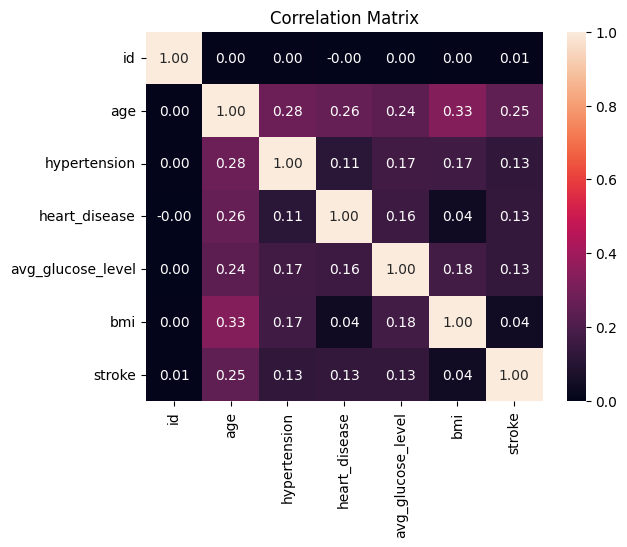

In [ ]:
# Show correlation matrix to check highly related variables
sns.heatmap(df.corr(numeric_only=True), annot=True,fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

Main Observation/s:

*   There are no variables that are significantly related to each other.




### Distribution of Age

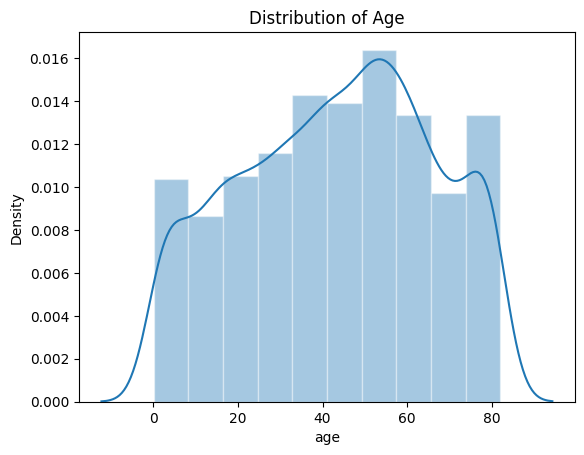

In [ ]:
sns.histplot(df['age'], kde=True, stat='density', kde_kws=dict(cut=3), bins=10,
             alpha=.4, edgecolor=(1, 1, 1, .4))
plt.title('Distribution of Age')
plt.show()

Main Observation/s:

### Distribution of Average Glucose Level

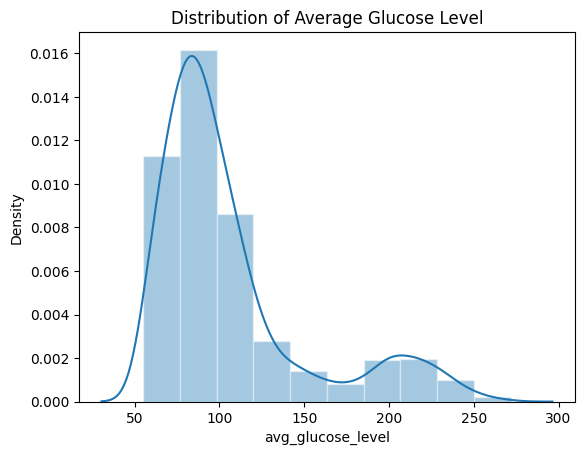

In [ ]:
sns.histplot(df['avg_glucose_level'], kde=True, stat='density', kde_kws=dict(cut=3), bins=10,
             alpha=.4, edgecolor=(1, 1, 1, .4))
plt.title('Distribution of Average Glucose Level')
plt.show()

Main Observation/s:

### Distribution of BMI

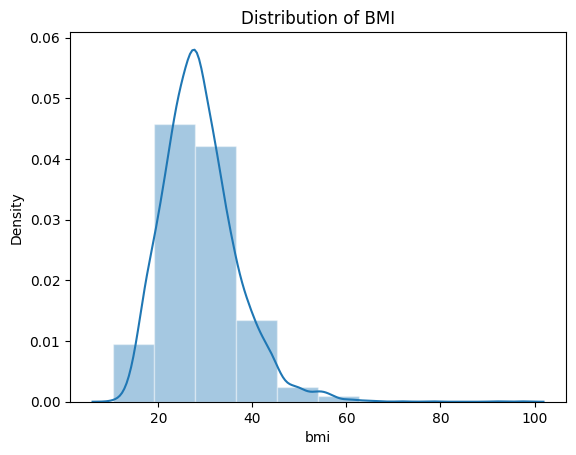

In [ ]:
sns.histplot(df['bmi'], kde=True, stat='density', kde_kws=dict(cut=3), bins=10,
             alpha=.4, edgecolor=(1, 1, 1, .4))
plt.title('Distribution of BMI')
plt.show()

Main Observation/s:

### Boxplot of BMI

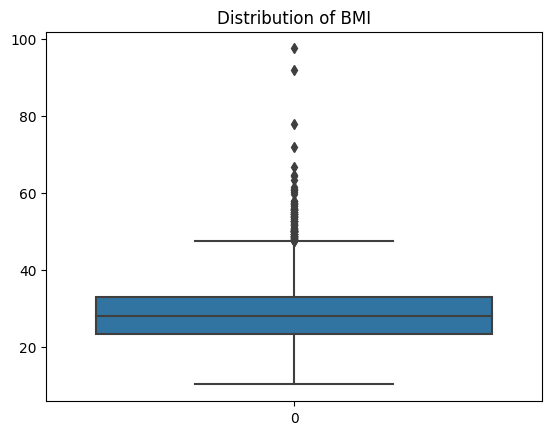

In [ ]:
sns.boxplot(df['bmi'])
plt.title('Distribution of BMI')
plt.show()

Main Observation/s:

## Data Cleaning and Feature Engineering

In [ ]:
# Copy the dataframe
df_wip = df.copy(deep=True)

In [ ]:
# Drop identifier columns; these columns are unnecessary for analysis (only 'id' is an identifier column)
df_wip = df_wip.drop(columns=['id'])

In [ ]:
# Check unique values for 'Gender'
df_wip['gender'].unique()

array(['Male', 'Female', 'Other'], dtype=object)

In [ ]:
# Check the entries under the value 'Other'
df_wip[df_wip['gender'] == 'Other']

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
3116,Other,26.0,0,0,No,Private,Rural,143.33,22.4,formerly smoked,0


In [ ]:
# There is only 1 data under the 'Other' gender
# It is safe to drop the data without heavily affecting the dataframe
df_wip = df_wip.drop(df_wip[df_wip['gender'] == 'Other'].index)

In [ ]:
# Convert the 'age' column to integer datatype
df_wip['age'] = df_wip['age'].astype(int)

In [ ]:
# Convert the 'ever_married' column into 'marital_status'
marital_status_values = {
    'Yes': 'married',
    'No': 'single'
}

df_wip['marital_status'] = df_wip['ever_married'].map(marital_status_values)
df_wip = df_wip.drop(columns=['ever_married'])

In [ ]:
work_type_values = {
    'Private': 'private',
    'Self-employed': 'self-employed',
    'Govt_job': 'government',
    'children': 'unemployed',
    'Never_worked': 'unemployed'
}

# Replace the values in 'work_type'
df_wip['work_type'] = df_wip['work_type'].replace(work_type_values)

In [ ]:
smoking_status_values = {
    'formerly smoked': 'former smoker',
    'never smoked': 'never smoked',
    'smokes': 'regular smoker',
    'Unknown': 'unknown',
}

# Replace the values in 'smoking_status'
df_wip['smoking_status'] = df_wip['smoking_status'].replace(smoking_status_values)

In [ ]:
# Define a function to classify 'age' into age groups
def classify_age(age):
  if age == 0:
    return 'infant'
  elif age > 0 and age <= 12:
    return 'child'
  elif age >= 13 and age <= 17:
    return 'adolescent'
  elif age >= 18 and age < 65:
    return 'adult'
  elif age >= 65:
    return 'older adult'

In [ ]:
# Apply the 'classify_age' function to the 'age' column and place the results in the new column, 'age_group'
df_wip['age_group'] = df_wip['age'].apply(classify_age)

In [ ]:
# 'bmi' column has missing values
# Impute these values based on the patients' 'age_group' and 'gender'
# Use the median value for bmi due to the presence of outliers (See Initial EDA for more information)
df_wip['bmi'] = df_wip.groupby(['age_group', 'gender'])['bmi'].transform(lambda x: x.fillna(x.median()))
df_wip['bmi'] = df_wip['bmi'].round(2)

In [ ]:
# Define a function to classify 'bmi' into weight groups
def classify_bmi(bmi):
  if bmi < 16.5:
    return 'severely underweight'
  elif bmi >= 16.5 and bmi < 18.5:
    return 'underweight'
  elif bmi >= 18.5 and bmi < 25:
    return 'normal weight'
  elif bmi >= 25 and bmi < 30:
    return 'overweight'
  elif bmi >= 30 and bmi < 35:
    return 'obese i'
  elif bmi >= 35 and bmi < 40:
    return 'obese ii'
  elif bmi >= 40:
    return 'obese iii'

In [ ]:
# Apply the 'classify_bmi' function to the 'bmi' column and place the results in the new column, 'weight_group'
df_wip['weight_group'] = df_wip['bmi'].apply(classify_bmi)

In [ ]:
# Define functions to classify 'avg_glucose_level'
## classify_glucose_fpg: classification based on 'Fasting Plasma Glucose Test'
## source: https://medlineplus.gov/ency/imagepages/19723.htm
def classify_glucose_fpg(avg_glucose_level):
  if avg_glucose_level < 100:
    return 'normal'
  elif avg_glucose_level >=100 and avg_glucose_level <= 125:
    return 'pre-diabetic'
  elif avg_glucose_level > 125:
    return 'diabetic'

## classify_glucose_ogtt: classification based on 'Oral Glucose Tolerance Test'
## source: https://medlineplus.gov/ency/imagepages/19810.htm
def classify_glucose_ogtt(avg_glucose_level):
  if avg_glucose_level < 140:
    return 'normal'
  elif avg_glucose_level >=140 and avg_glucose_level <= 200:
    return 'pre-diabetic'
  elif avg_glucose_level > 200:
    return 'diabetic'

In [ ]:
# Apply the 'classify_glucose' function to the 'avg_glucose_level' column
# 'classify_glucose_fpg' is used
#df_wip['glucose_status'] = df_wip['avg_glucose_level'].apply(classify_glucose_fpg)

In [ ]:
# Copy the dataframe to 'df_complete'
df_complete = df_wip.copy(deep=True)

In [ ]:
# Drop the 'age', 'bmi', 'avg_glucose_level' column to avoid redundancy in data
df_wip = df_wip.drop(columns=['bmi'])

In [ ]:
# Drop other unnecessary columns
df_wip = df_wip.drop(columns=['work_type', 'residence_type', 'marital_status'])

In [ ]:
# Copy the dataframe to 'df_clean'
df_clean = df_wip.copy(deep=True)

In [ ]:
display(df_clean.info(), df_clean.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5109 entries, 0 to 5109
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5109 non-null   object 
 1   age                5109 non-null   int64  
 2   hypertension       5109 non-null   int64  
 3   heart_disease      5109 non-null   int64  
 4   avg_glucose_level  5109 non-null   float64
 5   smoking_status     5109 non-null   object 
 6   stroke             5109 non-null   int64  
 7   age_group          5109 non-null   object 
 8   weight_group       5109 non-null   object 
dtypes: float64(1), int64(4), object(4)
memory usage: 399.1+ KB


None

,gender,age,hypertension,heart_disease,avg_glucose_level,smoking_status,stroke,age_group,weight_group
0,Male,67,0,1,228.69,former smoker,1,older adult,obese ii
1,Female,61,0,0,202.21,never smoked,1,adult,overweight
2,Male,80,0,1,105.92,never smoked,1,older adult,obese i
3,Female,49,0,0,171.23,regular smoker,1,adult,obese i
4,Female,79,1,0,174.12,never smoked,1,older adult,normal weight


## Further EDA

### Distribution of Categorized Values

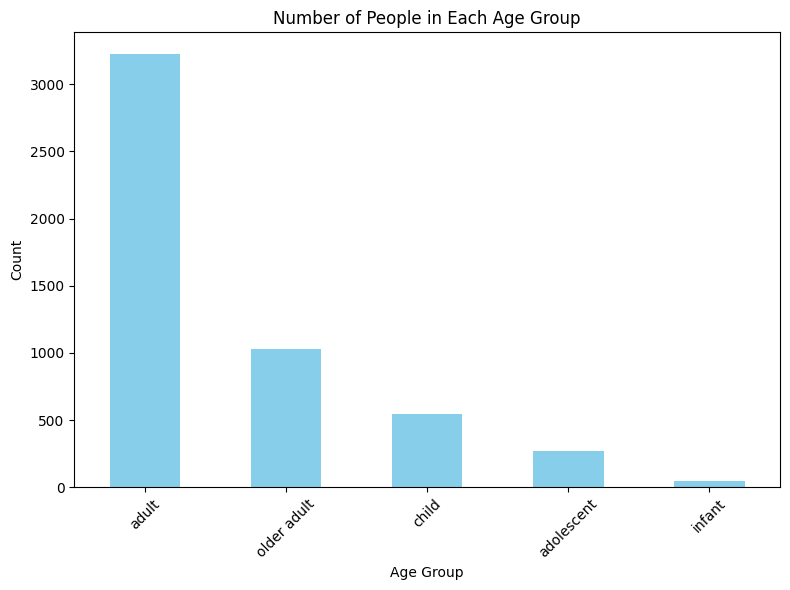

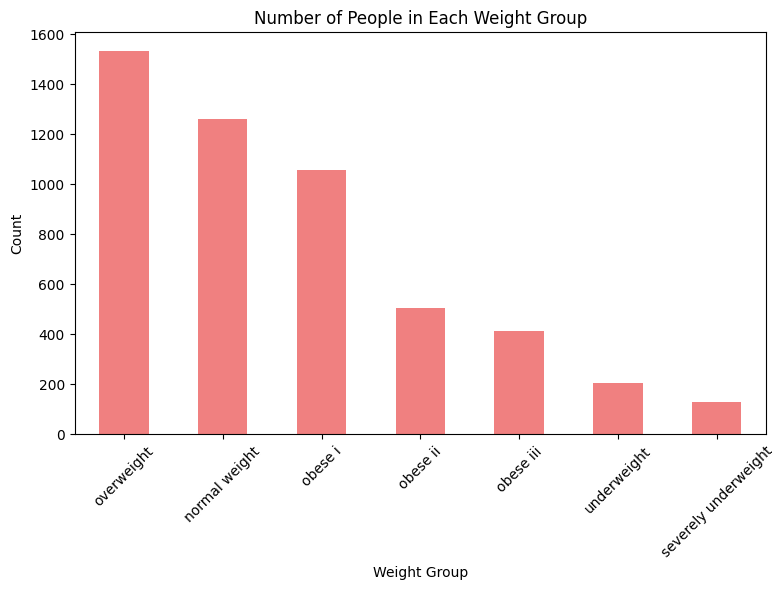

In [ ]:
# Bar plot for 'age_group'
plt.figure(figsize=(8, 6))  # Set the figure size
df_clean['age_group'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Number of People in Each Age Group')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.tight_layout()  # Ensure labels are not cut off
plt.show()

# Bar plot for 'weight_group'
plt.figure(figsize=(8, 6))  # Set the figure size
df_clean['weight_group'].value_counts().plot(kind='bar', color='lightcoral')
plt.title('Number of People in Each Weight Group')
plt.xlabel('Weight Group')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.tight_layout()  # Ensure labels are not cut off
plt.show()

### Outlier Detection via Local Outlier Factors

In [ ]:
df_outliers = df_complete.copy(deep=True)
df_outliers_num = df_outliers[['avg_glucose_level', 'bmi']]
df_outliers_num.head()

,avg_glucose_level,bmi
0,228.69,36.6
1,202.21,28.8
2,105.92,32.5
3,171.23,34.4
4,174.12,24.0


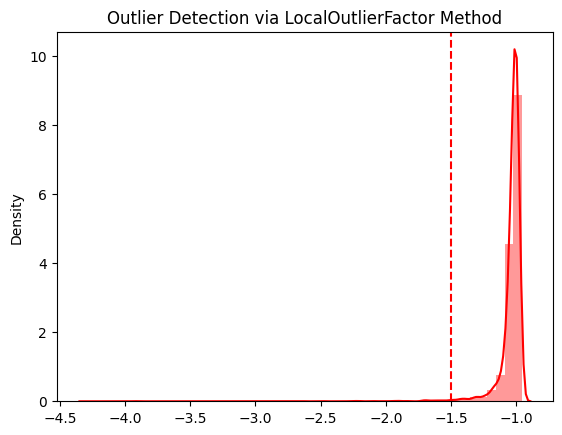

In [ ]:
lof = LocalOutlierFactor()

y_pred_lof = lof.fit_predict(df_outliers_num)
lof_scores = lof.negative_outlier_factor_

sns.distplot(lof_scores, color='r')
plt.axvline(-1.5, linestyle='--', color='r')
plt.title('Outlier Detection via LocalOutlierFactor Method')
plt.show()



In [ ]:
y_pred_lof = (lof_scores > -1.5) * 2 - 1
df_outliers['lof_score'] = y_pred_lof

df_outliers_only = df_outliers[df_outliers['lof_score']==-1]

print('Characteristics of Dropped Outliers \n')
print(df_outliers.value_counts('lof_score'), '\n')
print(df_outliers_only.value_counts('weight_group'), '\n')
print(df_outliers_only.value_counts('glucose_status'))

Characteristics of Dropped Outliers 

lof_score
 1    5062
-1      47
dtype: int64 

weight_group
obese iii               30
severely underweight    13
normal weight            2
obese i                  1
underweight              1
dtype: int64 

glucose_status
diabetic        22
normal          16
pre-diabetic     9
dtype: int64


**Observation**

We have chosen to retain the identified outliers since it is all the more important to understand the stroke risk of people with high BMI and glucose levels

## One-Hot Encoding

In [ ]:
# Copy the dataframe to 'df_onehot'
df_onehot = df_clean.copy(deep=True)

In [ ]:
## One-Hot Encode Categorical Features
to_drop = []
for col in df_onehot:
    if df_onehot[col].dtype == 'object':
        dummies = pd.get_dummies(df_onehot[col], prefix=col, drop_first=False)
        df_onehot = pd.concat([df_onehot, dummies], axis=1)
        to_drop.append(col)
df_onehot = df_onehot.drop(to_drop, axis=1)
df_onehot.head()

,age,hypertension,heart_disease,avg_glucose_level,stroke,gender_Female,gender_Male,smoking_status_former smoker,smoking_status_never smoked,smoking_status_regular smoker,...,age_group_child,age_group_infant,age_group_older adult,weight_group_normal weight,weight_group_obese i,weight_group_obese ii,weight_group_obese iii,weight_group_overweight,weight_group_severely underweight,weight_group_underweight
0,67,0,1,228.69,1,0,1,1,0,0,...,0,0,1,0,0,1,0,0,0,0
1,61,0,0,202.21,1,1,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,80,0,1,105.92,1,0,1,0,1,0,...,0,0,1,0,1,0,0,0,0,0
3,49,0,0,171.23,1,1,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
4,79,1,0,174.12,1,1,0,0,1,0,...,0,0,1,1,0,0,0,0,0,0


In [ ]:
# Rearrange the columns
col = ['gender_Male', 'gender_Female',
       'age_group_infant', 'age_group_child', 'age_group_adolescent', 'age_group_adult', 'age_group_older adult',
       'weight_group_severely underweight', 'weight_group_underweight', 'weight_group_normal weight',
       'weight_group_overweight', 'weight_group_obese i', 'weight_group_obese ii', 'weight_group_obese iii',
       'hypertension', 'heart_disease',
       'smoking_status_never smoked', 'smoking_status_former smoker', 'smoking_status_regular smoker', 'smoking_status_unknown',
       'avg_glucose_level',
       #'glucose_status_normal', 'glucose_status_pre-diabetic', 'glucose_status_diabetic',
       'stroke']
df_onehot = df_onehot[col]

In [ ]:
display(df_onehot.head())

,gender_Male,gender_Female,age_group_infant,age_group_child,age_group_adolescent,age_group_adult,age_group_older adult,weight_group_severely underweight,weight_group_underweight,weight_group_normal weight,...,weight_group_obese ii,weight_group_obese iii,hypertension,heart_disease,smoking_status_never smoked,smoking_status_former smoker,smoking_status_regular smoker,smoking_status_unknown,avg_glucose_level,stroke
0,1,0,0,0,0,0,1,0,0,0,...,1,0,0,1,0,1,0,0,228.69,1
1,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,202.21,1
2,1,0,0,0,0,0,1,0,0,0,...,0,0,0,1,1,0,0,0,105.92,1
3,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,171.23,1
4,0,1,0,0,0,0,1,0,0,1,...,0,0,1,0,1,0,0,0,174.12,1


## Final DataFrame

In [ ]:
# Copy the one-hot encoded dataframe to 'df_final'
df_final = df_onehot.copy(deep=True)

In [ ]:
display(df_final.head())

,gender_Male,gender_Female,age_group_infant,age_group_child,age_group_adolescent,age_group_adult,age_group_older adult,weight_group_severely underweight,weight_group_underweight,weight_group_normal weight,...,weight_group_obese ii,weight_group_obese iii,hypertension,heart_disease,smoking_status_never smoked,smoking_status_former smoker,smoking_status_regular smoker,smoking_status_unknown,avg_glucose_level,stroke
0,1,0,0,0,0,0,1,0,0,0,...,1,0,0,1,0,1,0,0,228.69,1
1,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,202.21,1
2,1,0,0,0,0,0,1,0,0,0,...,0,0,0,1,1,0,0,0,105.92,1
3,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,171.23,1
4,0,1,0,0,0,0,1,0,0,1,...,0,0,1,0,1,0,0,0,174.12,1


# Machine Learning Modelling

## Proportion Chance Criterion (PCC)

Would Recommend:
   count
1    249
0   4860

Proportional Chance Criterion: 90.73%
1.25*Proportional Chance Criterion: 113.41%

Evaluating other Metrics
Positive Ratio: 4.87%
1.25*Positive Ratio: 6.09%



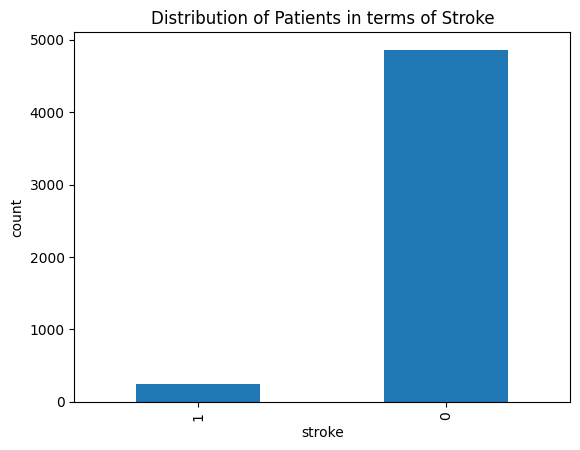

In [ ]:
# Evaluate the distribution of patients with and without stroke
stroke_count = Counter(df_onehot['stroke'])
df_stroke = pd.DataFrame.from_dict(stroke_count, orient='index', columns=['count'])
ax = df_stroke.plot(kind='bar', legend=False)
ax.set_xlabel('stroke')
ax.set_ylabel('count')
ax.set_title('Distribution of Patients in terms of Stroke')

print(f'Would Recommend:\n{df_stroke}')

# Calculate the Proportional Chance Criterion (PCC)
pcc_acc = (df_stroke['count'] / df_stroke['count'].sum()) ** 2
pcc_acc_sum = 100*pcc_acc.sum()
pcc_acc_safe = 1.25*100*pcc_acc.sum()

## Positive Score
p_class = (df_stroke.loc[1, 'count'] / ((df_stroke.loc[1, 'count']) + (df_stroke.loc[0, 'count'])))

print(f'\nProportional Chance Criterion: {pcc_acc_sum:0.2f}%')
print(f'1.25*Proportional Chance Criterion: {pcc_acc_safe:0.2f}%')

print('\nEvaluating other Metrics')
print('Positive Ratio: {:0.2f}%'.format(100*p_class))
print('1.25*Positive Ratio: {:0.2f}%\n'.format(1.25*100*p_class))

plt.show()

## Train-Validation-Holdout Split

In [ ]:
# Train-Validation-Holdout Split
## X: features, the parameter/s used to predict the target
X = df_final.drop(['stroke'], axis=1)
## y: target, the parameter to be predicted by the model
y = df_final['stroke']

## X_trainval: set of data to be used for training and validating the model
## X_holdout: set of data to be hidden from the model, used for testing the model
## y_trainval: target of the data used for training and validating the model
## y_holdout: target of the data hidden from the model
## stratify = y: ensures that the distribution within each split is consistent with the original data
(X_trainval, X_holdout, y_trainval, y_holdout) = train_test_split(X, y, random_state=42, test_size=0.25, stratify=y)

## Auto Machine Learning (AutoML) Function

In [ ]:
# Define a function that evalutes models based on the parameters given
## X = features
## y = target
## model_dict = dictionary; contains the machine learning models to be used
## cv = cross-validation method
## resampling = resampling technique to be used
def auto_ml(X, y, model_dict, cv=None, resampling=None):

    results = {}
    results_plot = {}

    for model_name, model in tqdm(model_dict.items()):

        ##### Enter the metrics to be evaluated below #####
        train_accuracy = []
        val_accuracy = []

        train_precision = []
        val_precision = []

        train_recall = []
        val_recall = []

        train_f1 = []
        val_f1 = []

        runtime = []
        ##################################################

        for train_index, val_index in tqdm(cv.split(X, y)):

            X_train, X_val = X.iloc[train_index], X.iloc[val_index]
            y_train, y_val = y.iloc[train_index], y.iloc[val_index]

            # Apply resampling technique
            if resampling is not None:
                X_train, y_train = resampling.fit_resample(X_train, y_train)
            else:
                pass

            # Record the start time for model fitting
            start_time = time.time()

            # Fit the model
            model.fit(X_train, y_train)

            # Use the model to predict the target
            train_preds = model.predict(X_train)
            val_preds = model.predict(X_val)

            # Record the end time for model fitting
            end_time = time.time()

            ##### Evaluation Metrics #####
            # Accuracy
            train_accuracy.append(model.score(X_train, y_train))
            val_accuracy.append(model.score(X_val, y_val))

            # Precision
            train_precision.append(precision_score(y_train, train_preds))
            val_precision.append(precision_score(y_val, val_preds))

            # Recall
            train_recall.append(recall_score(y_train, train_preds))
            val_recall.append(recall_score(y_val, val_preds))

            # F1-Score
            train_f1.append(f1_score(y_train, train_preds))
            val_f1.append(f1_score(y_val, val_preds))

            # Runtime
            runtime.append(end_time-start_time)
            ##############################

            results[model_name] = {
                'Train Accuracy': np.round(np.mean(train_accuracy) * 100, 2),
                'Val Accuracy': np.round(np.mean(val_accuracy) * 100, 2),
                'Train Precision': np.round(np.mean(train_precision) * 100, 2),
                'Val Precision': np.round(np.mean(val_precision) * 100, 2),
                'Train Recall': np.round(np.mean(train_recall) * 100, 2),
                'Val Recall': np.round(np.mean(val_recall) * 100, 2),
                'Train F1-Score': np.round(np.mean(train_f1) * 100, 2),
                'Val F1-Score': np.round(np.mean(val_f1) * 100, 2),
                'Runtime': np.round(np.sum(runtime), 2)
            }

            results_plot[model_name] = {
                'Train Accuracy': '{:.2f}%'.format(np.round(np.mean(train_accuracy)*100, 2)),
                'Val Accuracy': '{:.2f}%'.format(np.round(np.mean(val_accuracy)*100, 2)),
                'Train Precision': '{:.2f}%'.format(np.round(np.mean(train_precision)*100, 2)),
                'Val Precision': '{:.2f}%'.format(np.round(np.mean(val_precision)*100, 2)),
                'Train Recall': '{:.2f}%'.format(np.round(np.mean(train_recall)*100, 2)),
                'Val Recall': '{:.2f}%'.format(np.round(np.mean(val_recall)*100, 2)),
                'Train F1-Score': '{:.2f}%'.format(np.round(np.mean(train_f1)*100, 2)),
                'Val F1-Score': '{:.2f}%'.format(np.round(np.mean(val_f1)*100, 2)),
                'Runtime': '{:.2f}s'.format(np.round(np.sum(runtime), 2))
            }

    results = pd.DataFrame(results).transpose()
    results_plot = pd.DataFrame(results_plot).transpose()
    return [results, results_plot]

## Machine Learning Model Dictionary

In [ ]:
# Create a dictionary to set the models to be created
model_dict = {
    'KNeighborsClassifier': KNeighborsClassifier(),
    'LogisticRegression': LogisticRegression(random_state=42),
    'DecisionTreeClassifier': DecisionTreeClassifier(random_state=42),
    'RandomForestClassifier': RandomForestClassifier(random_state=42),
    'GradientBoostingClassifier': GradientBoostingClassifier(random_state=42),
    'AdaBoostClassifier': AdaBoostClassifier(random_state=42),
    'ExtraTreesClassifier': ExtraTreesClassifier(random_state=42),
    'XGBClassifier': XGBClassifier(random_state=42)
}

## Base Model Creation

Target Accuracy: 113.41%

Other Metrics: 6.09%

In [ ]:
base_model = auto_ml(X_trainval, y_trainval, model_dict, cv=StratifiedKFold(n_splits=5))
base_model[1]

  0%|          | 0/8 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

,Train Accuracy,Val Accuracy,Train Precision,Val Precision,Train Recall,Val Recall,Train F1-Score,Val F1-Score,Runtime
KNeighborsClassifier,95.16%,94.83%,62.94%,20.00%,2.67%,0.54%,5.11%,1.05%,2.66s
LogisticRegression,95.13%,95.12%,40.00%,0.00%,0.27%,0.00%,0.53%,0.00%,0.45s
DecisionTreeClassifier,99.98%,90.53%,100.00%,10.47%,99.60%,12.38%,99.80%,11.25%,0.24s
RandomForestClassifier,99.98%,92.74%,100.00%,10.23%,99.60%,7.55%,99.80%,8.60%,4.02s
GradientBoostingClassifier,95.88%,94.57%,99.23%,3.33%,15.78%,0.53%,27.18%,0.91%,5.78s
AdaBoostClassifier,95.15%,95.01%,66.00%,40.00%,1.87%,1.61%,3.63%,3.08%,2.37s
ExtraTreesClassifier,99.98%,91.33%,100.00%,7.77%,99.60%,8.08%,99.80%,7.87%,3.98s
XGBClassifier,97.74%,94.15%,99.30%,15.42%,54.01%,5.36%,69.88%,7.88%,4.52s


## Applying Sampling Techniques

In [ ]:
resampling_tech = [
    ('SMOTE', SMOTE(random_state=42)),
    ('SMOTE-N', SMOTEN(random_state=42)),
    ('ADASYN', ADASYN(random_state=42)),
    ('TomekLinks', TomekLinks())
]

In [ ]:
resampling_summary = []
for resampling_name, resampling in resampling_tech:
    print(colored(resampling_name, 'red', attrs=['bold']).center(120,'-'))
    resampling_model = auto_ml(X_trainval, y_trainval, model_dict, cv=StratifiedKFold(n_splits=5), resampling=resampling)
    resampling_summary.append(resampling_model[0])
    display(resampling_model[1])

---------------------------------------------------------SMOTE----------------------------------------------------------


  0%|          | 0/8 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

,Train Accuracy,Val Accuracy,Train Precision,Val Precision,Train Recall,Val Recall,Train F1-Score,Val F1-Score,Runtime
KNeighborsClassifier,92.61%,78.00%,87.65%,9.25%,99.20%,40.17%,93.07%,15.02%,8.77s
LogisticRegression,95.63%,94.86%,99.56%,28.00%,91.66%,2.13%,95.44%,3.67%,1.98s
DecisionTreeClassifier,99.99%,90.29%,100.00%,11.50%,99.98%,15.58%,99.99%,13.15%,0.18s
RandomForestClassifier,99.98%,92.04%,100.00%,8.93%,99.96%,8.09%,99.98%,8.46%,4.61s
GradientBoostingClassifier,95.62%,93.00%,97.81%,8.85%,93.34%,4.27%,95.52%,5.72%,3.40s
AdaBoostClassifier,95.21%,93.34%,97.94%,20.57%,92.38%,9.57%,95.07%,11.56%,1.76s
ExtraTreesClassifier,99.99%,91.28%,100.00%,8.21%,99.98%,8.61%,99.99%,8.36%,2.57s
XGBClassifier,98.87%,94.02%,99.86%,15.63%,97.87%,4.82%,98.86%,7.36%,2.17s


--------------------------------------------------------SMOTE-N---------------------------------------------------------


  0%|          | 0/8 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

,Train Accuracy,Val Accuracy,Train Precision,Val Precision,Train Recall,Val Recall,Train F1-Score,Val F1-Score,Runtime
KNeighborsClassifier,96.59%,91.07%,97.21%,6.25%,95.94%,5.87%,96.57%,6.05%,2.85s
LogisticRegression,89.76%,87.89%,90.89%,11.80%,88.38%,23.02%,89.60%,15.54%,0.49s
DecisionTreeClassifier,99.99%,90.03%,100.00%,5.40%,99.98%,6.42%,99.99%,5.85%,0.11s
RandomForestClassifier,99.98%,92.14%,100.00%,8.58%,99.96%,7.55%,99.98%,7.91%,3.06s
GradientBoostingClassifier,95.94%,91.75%,96.48%,11.73%,95.35%,11.29%,95.91%,11.38%,3.06s
AdaBoostClassifier,92.32%,88.05%,91.91%,11.48%,92.82%,21.39%,92.36%,14.94%,1.83s
ExtraTreesClassifier,99.99%,91.18%,100.00%,7.84%,99.98%,8.61%,99.99%,8.15%,3.21s
XGBClassifier,98.71%,93.53%,99.78%,16.37%,97.63%,8.05%,98.70%,10.60%,0.80s


---------------------------------------------------------ADASYN---------------------------------------------------------


  0%|          | 0/8 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

,Train Accuracy,Val Accuracy,Train Precision,Val Precision,Train Recall,Val Recall,Train F1-Score,Val F1-Score,Runtime
KNeighborsClassifier,92.70%,77.58%,87.77%,9.39%,99.28%,41.76%,93.17%,15.31%,4.03s
LogisticRegression,95.52%,94.65%,99.25%,11.82%,91.76%,2.15%,95.36%,3.57%,0.99s
DecisionTreeClassifier,99.99%,90.50%,100.00%,10.44%,99.98%,13.46%,99.99%,11.65%,0.11s
RandomForestClassifier,99.98%,91.91%,99.99%,7.80%,99.97%,7.01%,99.98%,7.36%,2.96s
GradientBoostingClassifier,95.70%,93.11%,98.01%,10.89%,93.32%,5.35%,95.61%,7.12%,4.32s
AdaBoostClassifier,95.25%,93.74%,97.81%,19.29%,92.61%,7.50%,95.14%,10.11%,1.75s
ExtraTreesClassifier,99.99%,91.20%,100.00%,8.55%,99.98%,9.15%,99.99%,8.78%,2.65s
XGBClassifier,98.85%,93.81%,99.90%,8.25%,97.80%,2.66%,98.84%,4.02%,0.77s


-------------------------------------------------------TomekLinks-------------------------------------------------------


  0%|          | 0/8 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

,Train Accuracy,Val Accuracy,Train Precision,Val Precision,Train Recall,Val Recall,Train F1-Score,Val F1-Score,Runtime
KNeighborsClassifier,95.12%,94.68%,69.29%,22.50%,3.88%,1.07%,7.32%,1.92%,1.97s
LogisticRegression,95.02%,95.12%,50.00%,0.00%,0.40%,0.00%,0.79%,0.00%,0.39s
DecisionTreeClassifier,99.98%,90.03%,100.00%,9.45%,99.60%,11.83%,99.80%,10.46%,0.08s
RandomForestClassifier,99.97%,91.91%,100.00%,8.64%,99.47%,8.09%,99.73%,8.29%,2.01s
GradientBoostingClassifier,95.92%,94.60%,98.66%,11.11%,18.45%,1.59%,31.02%,2.70%,2.03s
AdaBoostClassifier,95.09%,95.07%,67.56%,36.67%,3.07%,1.61%,5.86%,3.05%,1.46s
ExtraTreesClassifier,99.98%,90.63%,100.00%,7.26%,99.60%,8.62%,99.80%,7.82%,2.35s
XGBClassifier,98.05%,93.58%,99.32%,12.69%,61.37%,5.90%,75.74%,8.03%,0.51s


In [ ]:
summary = pd.DataFrame(index=model_dict.keys())
summary['NoResampling Val Recall'] = base_model[0]['Val Recall']
summary['SMOTE Val Recall'] = resampling_summary[0]['Val Recall']
summary['SMOTE-N Val Recall'] = resampling_summary[1]['Val Recall']
summary['ADASYN Val Recall'] = resampling_summary[2]['Val Recall']
summary['TomekLinks Val Recall'] = resampling_summary[3]['Val Recall']
summary

,NoResampling Val Recall,SMOTE Val Recall,SMOTE-N Val Recall,ADASYN Val Recall,TomekLinks Val Recall
KNeighborsClassifier,0.54,40.17,5.87,41.76,1.07
LogisticRegression,0.00,2.13,23.02,2.15,0.00
DecisionTreeClassifier,12.38,15.58,6.42,13.46,11.83
RandomForestClassifier,7.55,8.09,7.55,7.01,8.09
GradientBoostingClassifier,0.53,4.27,11.29,5.35,1.59
AdaBoostClassifier,1.61,9.57,21.39,7.50,1.61
ExtraTreesClassifier,8.08,8.61,8.61,9.15,8.62
XGBClassifier,5.36,4.82,8.05,2.66,5.90


# Hyperparameter Tuning

## Hyperparameter Tuning Function

In [ ]:
def hypertune_ml(X, y, model, param_grid, metric, cv=None, scaler=MinMaxScaler(), resampling=ADASYN(random_state=42)):

    hpt_metrics = {}

    if resampling is not None:
      hpt_pipeline = Pipeline([('scaler', scaler), ('resampling', resampling), ('model', model)])
    else:
      hpt_pipeline = Pipeline([('scaler', scaler), ('model', model)])

    new_param = {'model__' +
                 key: param_grid[key] for key in param_grid}

    hpt = GridSearchCV(hpt_pipeline, param_grid=new_param, scoring=metric, cv=cv,
                             return_train_score=True)

    start = time.time()
    hpt.fit(X, y)
    end = time.time()

    hpt_model = hpt.best_estimator_.fit(X, y)
    hpt_params = hpt.best_params_
    hpt_train = np.mean(hpt.cv_results_['mean_train_score'])
    hpt_val = hpt.best_score_

    hpt_metrics[metric] = {
        'Train Metric': 100*hpt_train,
        'Val Metric': 100*hpt_val
    }

    hpt_metrics = pd.DataFrame(hpt_metrics).transpose()

    return [f'Best Parameters: {hpt_params}',
            f'Train Metric: {100*hpt_train:0.2f}%',
            f'Val Metric: {100*hpt_val:0.2f}%',
            f'Runtime: {end-start:0.2f}s',
            hpt_metrics,
            hpt_model]

## Hyperparameter Tuning w/ Resampling

In [ ]:
# KNeighborsClassifier
param_grid = {
    'n_neighbors': [2,4,6,8,10]
}

knn = hypertune_ml(X_trainval, y_trainval,
                   KNeighborsClassifier(), param_grid, 'recall', cv=StratifiedKFold(n_splits=5))
knn

["Best Parameters: {'model__n_neighbors': 10}",
 'Train Metric: 75.48%',
 'Val Metric: 30.53%',
 'Runtime: 10.92s',
         Train Metric  Val Metric
 recall       75.4817   30.526316,
 Pipeline(steps=[('scaler', MinMaxScaler()),
                 ('resampling', ADASYN(random_state=42)),
                 ('model', KNeighborsClassifier(n_neighbors=10))])]

In [ ]:
# LogisticRegression
param_grid = {
    'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]
}

lr = hypertune_ml(X_trainval, y_trainval,
                   LogisticRegression(random_state=42), param_grid, 'recall', cv=StratifiedKFold(n_splits=5))
lr

["Best Parameters: {'model__C': 1}",
 'Train Metric: 69.92%',
 'Val Metric: 72.20%',
 'Runtime: 4.04s',
         Train Metric  Val Metric
 recall     69.919719   72.204836,
 Pipeline(steps=[('scaler', MinMaxScaler()),
                 ('resampling', ADASYN(random_state=42)),
                 ('model', LogisticRegression(C=1, random_state=42))])]

In [ ]:
# DecisionTreeClassifier
param_grid = {
    'max_depth': [3,4,5,6,7,8,9,10],
}

dt = hypertune_ml(X_trainval, y_trainval,
                   DecisionTreeClassifier(random_state=42), param_grid, 'recall', cv=StratifiedKFold(n_splits=5))
dt

["Best Parameters: {'model__max_depth': 3}",
 'Train Metric: 72.98%',
 'Val Metric: 68.44%',
 'Runtime: 1.84s',
         Train Metric  Val Metric
 recall     72.977964   68.435277,
 Pipeline(steps=[('scaler', MinMaxScaler()),
                 ('resampling', ADASYN(random_state=42)),
                 ('model',
                  DecisionTreeClassifier(max_depth=3, random_state=42))])]

In [ ]:
# RandomForestClassifier
param_grid = {
    'n_estimators': [150,200,250,300],
    'max_depth': [3,4,5,6,7,8,9,10]
}

rf = hypertune_ml(X_trainval, y_trainval,
                   RandomForestClassifier(random_state=42), param_grid, 'recall', cv=StratifiedKFold(n_splits=5))
rf

["Best Parameters: {'model__max_depth': 3, 'model__n_estimators': 150}",
 'Train Metric: 72.81%',
 'Val Metric: 66.81%',
 'Runtime: 182.67s',
         Train Metric  Val Metric
 recall     72.807802   66.813656,
 Pipeline(steps=[('scaler', MinMaxScaler()),
                 ('resampling', ADASYN(random_state=42)),
                 ('model',
                  RandomForestClassifier(max_depth=3, n_estimators=150,
                                         random_state=42))])]

In [ ]:
# GradientBoostingClassifier
param_grid = {
    'n_estimators': [100,150,200,250],
    'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1],
    'max_depth': [1,2,3,4,5]
}

gb = hypertune_ml(X_trainval, y_trainval,
                   GradientBoostingClassifier(random_state=42), param_grid, 'recall', cv=StratifiedKFold(n_splits=5))
gb

["Best Parameters: {'model__learning_rate': 0.05, 'model__max_depth': 1, 'model__n_estimators': 100}",
 'Train Metric: 68.77%',
 'Val Metric: 65.73%',
 'Runtime: 1126.40s',
         Train Metric  Val Metric
 recall     68.767919   65.732575,
 Pipeline(steps=[('scaler', MinMaxScaler()),
                 ('resampling', ADASYN(random_state=42)),
                 ('model',
                  GradientBoostingClassifier(learning_rate=0.05, max_depth=1,
                                             random_state=42))])]

In [ ]:
# AdaBoostClassifier
param_grid = {
    'n_estimators': [100,150,200,250],
    'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1],
    'base_estimator__max_depth': [1,2,3,4,5]
}

ab = hypertune_ml(X_trainval, y_trainval,
                   AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=42), random_state=42),
                   param_grid, 'recall', cv=StratifiedKFold(n_splits=5))
ab

["Best Parameters: {'model__base_estimator__max_depth': 3, 'model__learning_rate': 0.001, 'model__n_estimators': 100}",
 'Train Metric: 71.00%',
 'Val Metric: 67.91%',
 'Runtime: 1599.36s',
         Train Metric  Val Metric
 recall     71.004219   67.908962,
 Pipeline(steps=[('scaler', MinMaxScaler()),
                 ('resampling', ADASYN(random_state=42)),
                 ('model',
                  AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3,
                                                                           random_state=42),
                                     learning_rate=0.001, n_estimators=100,
                                     random_state=42))])]

In [ ]:
# ExtraTreesClassifier
param_grid = {
    'n_estimators': [100,150,200,250],
    'max_depth': [1,2,3,4,5]
}

et = hypertune_ml(X_trainval, y_trainval,
                   ExtraTreesClassifier(random_state=42), param_grid, 'recall', cv=StratifiedKFold(n_splits=5))
et

["Best Parameters: {'model__max_depth': 3, 'model__n_estimators': 200}",
 'Train Metric: 66.88%',
 'Val Metric: 66.30%',
 'Runtime: 61.89s',
         Train Metric  Val Metric
 recall      66.87821   66.301565,
 Pipeline(steps=[('scaler', MinMaxScaler()),
                 ('resampling', ADASYN(random_state=42)),
                 ('model',
                  ExtraTreesClassifier(max_depth=3, n_estimators=200,
                                       random_state=42))])]

In [ ]:
# XGBClassifier
param_grid = {
    'n_estimators': [100,150,200,250],
    'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1],
    'max_depth': [1,2,3,4,5]
}

xgb = hypertune_ml(X_trainval, y_trainval,
                   XGBClassifier(random_state=42), param_grid, 'recall', cv=StratifiedKFold(n_splits=5))
xgb

["Best Parameters: {'model__learning_rate': 0.01, 'model__max_depth': 2, 'model__n_estimators': 200}",
 'Train Metric: 64.17%',
 'Val Metric: 66.29%',
 'Runtime: 249.09s',
         Train Metric  Val Metric
 recall     64.173851    66.28734,
 Pipeline(steps=[('scaler', MinMaxScaler()),
                 ('resampling', ADASYN(random_state=42)),
                 ('model',
                  XGBClassifier(base_score=None, booster=None, callbacks=None,
                                colsample_bylevel=None, colsample_bynode=None,
                                colsample_bytree=None, device=None,
                                early_stopping_rounds=None,
                                enable_categorical=False, eval_metric=None,
                                feature_types=None, gamma=None, grow_policy=None,
                                importance_type=None,
                                interaction_constraints=None, learning_rate=0.01,
                                max_bin=None, max

## Summary of Results

In [ ]:
hpt_summary = pd.DataFrame(columns=['HyperTuned Model + ADASYN', 'Train Recall', 'Val Recall', 'Runtime (s)'])
hpt_summary.loc[0] = ['KNeighborsClassifier', knn[-2]['Train Metric'][0], knn[-2]['Val Metric'][0],float(knn[-3][9:-1])]
hpt_summary.loc[1] = ['LogisticRegression', lr[-2]['Train Metric'][0], lr[-2]['Val Metric'][0], float(lr[-3][9:-1])]
hpt_summary.loc[2] = ['DecisionTreeClassifier', dt[-2]['Train Metric'][0], dt[-2]['Val Metric'][0],float(dt[-3][9:-1])]
hpt_summary.loc[3] = ['RandomForestClassifier', rf[-2]['Train Metric'][0], rf[-2]['Val Metric'][0],float(rf[-3][9:-1])]
hpt_summary.loc[4] = ['GradientBoostingClassifier', gb[-2]['Train Metric'][0], gb[-2]['Val Metric'][0],float(gb[-3][9:-1])]
hpt_summary.loc[5] = ['AdaBoostClassifier', ab[-2]['Train Metric'][0], ab[-2]['Val Metric'][0],float(ab[-3][9:-1])]
hpt_summary.loc[6] = ['ExtraTreesClassifier', et[-2]['Train Metric'][0], et[-2]['Val Metric'][0], float(et[-3][9:-1])]
hpt_summary.loc[7] = ['XGBClassifier', xgb[-2]['Train Metric'][0], xgb[-2]['Val Metric'][0], float(xgb[-3][9:-1])]

hpt_summary.insert(3, 'Difference', abs(hpt_summary['Train Recall'] - hpt_summary['Val Recall']))
hpt_summary.round(4)

,HyperTuned Model + ADASYN,Train Recall,Val Recall,Difference,Runtime (s)
0,KNeighborsClassifier,75.4817,30.5263,44.9554,10.92
1,LogisticRegression,69.9197,72.2048,2.2851,4.04
2,DecisionTreeClassifier,72.9780,68.4353,4.5427,1.84
3,RandomForestClassifier,72.8078,66.8137,5.9941,182.67
4,GradientBoostingClassifier,68.7679,65.7326,3.0353,1126.40
5,AdaBoostClassifier,71.0042,67.9090,3.0953,1599.36
6,ExtraTreesClassifier,66.8782,66.3016,0.5766,61.89
7,XGBClassifier,64.1739,66.2873,2.1135,249.09


In [ ]:
hpt_scores = hpt_summary.copy(deep=True)

# Score Columns based on quartiles
hpt_scores['Val Recall Score'] = pd.qcut(hpt_scores['Val Recall'], 4, labels=[4,3,2,1]) # Higher val  recall  will be given a better rank
hpt_scores['Difference Score'] = pd.qcut(hpt_scores['Difference'], 4, labels=[1,2,3,4]) # Higher differences will be given a lower rank

# Add Val Recall, Difference and Runtime Scores
hpt_scores['Total Score'] = hpt_scores.iloc[:, -2:].sum(axis=1)

# Rank models based on Lowest Total Score. Ties will be resolved by prioritizing models with faster runtimes.
hpt_scores['Rank'] = (hpt_scores.sort_values(by=['Total Score', 'Runtime (s)'], ascending=[False, True])['Total Score'].rank(method='first').astype(int))
hpt_scores.sort_values('Rank')

,HyperTuned Model + ADASYN,Train Recall,Val Recall,Difference,Runtime (s),Val Recall Score,Difference Score,Total Score,Rank
1,LogisticRegression,69.919719,72.204836,2.285118,4.04,1,2,3,1
2,DecisionTreeClassifier,72.977964,68.435277,4.542687,1.84,1,3,4,2
6,ExtraTreesClassifier,66.878210,66.301565,0.576646,61.89,3,1,4,3
7,XGBClassifier,64.173851,66.287340,2.113489,249.09,3,1,4,4
5,AdaBoostClassifier,71.004219,67.908962,3.095257,1599.36,2,3,5,5
3,RandomForestClassifier,72.807802,66.813656,5.994146,182.67,2,4,6,6
4,GradientBoostingClassifier,68.767919,65.732575,3.035345,1126.40,4,2,6,7
0,KNeighborsClassifier,75.481700,30.526316,44.955384,10.92,4,4,8,8


# Best Model

In [ ]:
joblib.dump(et[-1], 'final_model.twice')

['final_model.twice']

# SHapley Additive exPlanations (SHAP)

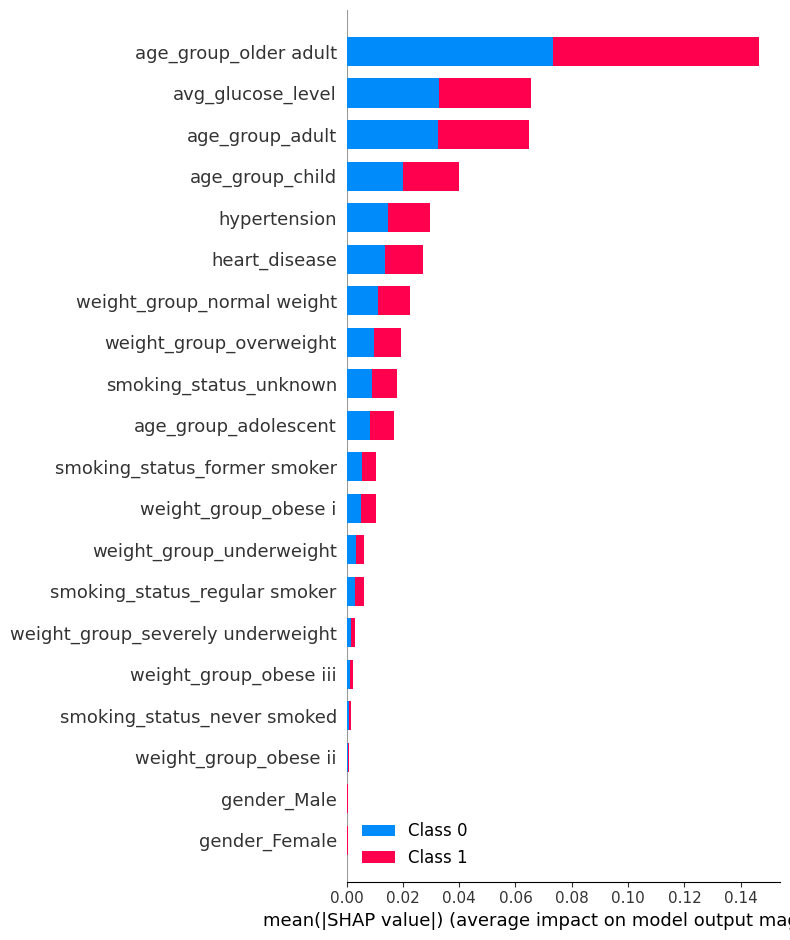

<Figure size 640x480 with 0 Axes>

In [ ]:
model = joblib.load('final_model.twice')
explainer = shap.TreeExplainer(model.named_steps['model'])
expected_values = explainer.expected_value
shap_values = explainer.shap_values(X_holdout)
shap.summary_plot(shap_values, X_holdout.columns, plot_type='bar')
plt.savefig('SHAP_summary.png')

# Holdout Prediction

In [ ]:
base_et = hypertune_ml(X_trainval, y_trainval, ExtraTreesClassifier(random_state=42), param_grid={},
                       metric='recall', cv=StratifiedKFold(n_splits=5), resampling=None)
base_et_model = base_et[-1]
y_base = base_et_model.predict(X_holdout)
y_preds = model.predict(X_holdout)

In [ ]:
holdout_recall = recall_score(y_holdout, y_preds)
print(f'Holdout Recall: {100*holdout_recall:0.2f}%')

Holdout Recall: 72.58%


In [ ]:
holdout_cm = confusion_matrix(y_holdout, y_preds)
base_cm = confusion_matrix(y_holdout, y_base)

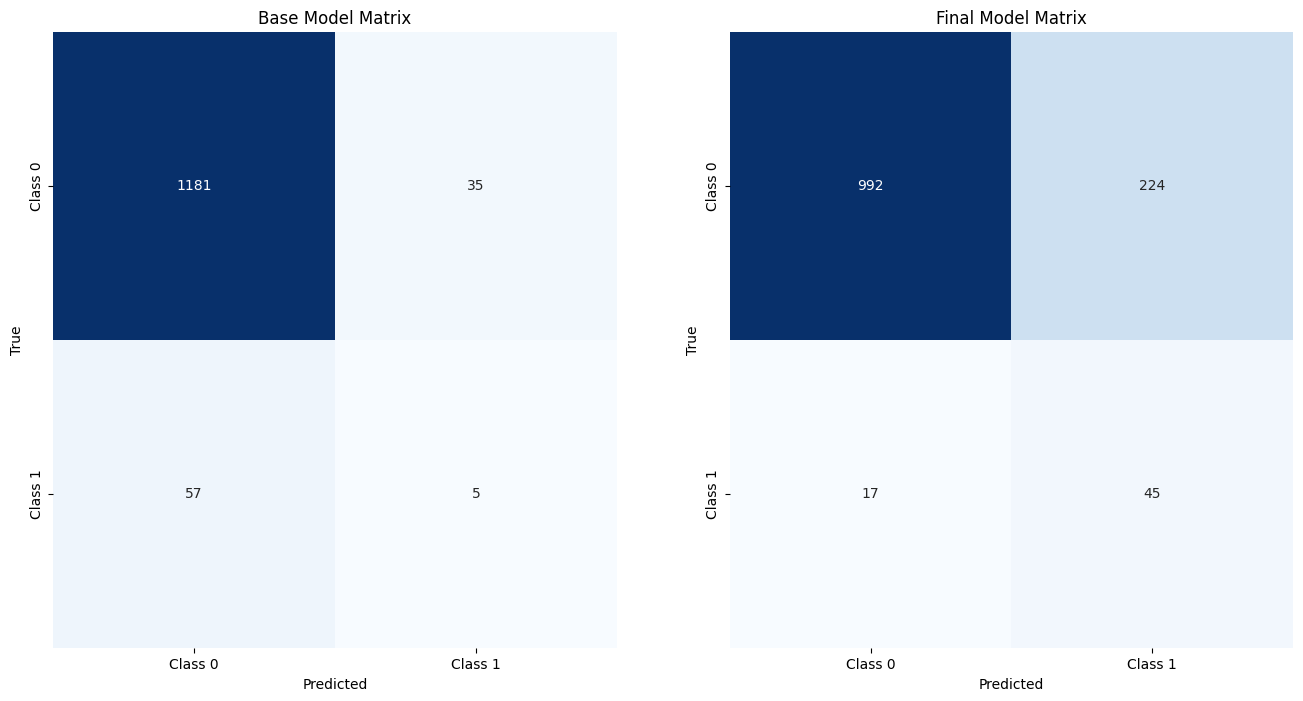

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16,8))

sns.heatmap(holdout_cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Class 0', 'Class 1'],
            yticklabels=['Class 0', 'Class 1'],
            ax=ax[1])
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('True')
ax[1].set_title('Final Model Matrix')

sns.heatmap(base_cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Class 0', 'Class 1'],
            yticklabels=['Class 0', 'Class 1'],
            ax=ax[0])
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('True')
ax[0].set_title('Base Model Matrix')
plt.show()